In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import pandas as pd

# 파일 경로 지정
file_path = 'C:/Users/Jun-Hyun Bae/Desktop/raw_data/국민100/sarcopenic_obesity/so_minmax.csv'

# read_csv 메서드를 사용하여 CSV 파일을 데이터프레임으로 불러옴
df = pd.read_csv(file_path)

# 불러온 데이터프레임 확인
print(df.head())

        Age    Height    Weight   Bodyfat       DBP       SBP      Grip  \
0  0.043478  0.676471  0.909134  0.356713  0.250000  0.395604  0.968354   
1  0.347826  0.137255  0.052532  0.342685  0.392857  0.131868  0.409283   
2  0.565217  0.311275  0.255088  0.452906  0.428571  0.373626  0.358650   
3  0.304348  0.056373  0.574539  0.809619  0.571429  0.439560  0.327004   
4  0.478261  0.450980  0.548982  0.507014  0.553571  0.725275  0.767932   

   NormalGrip  sitreach      BMI  ...       TUG  8walktestsec  relativegrip  \
0    0.845371  0.615385  0.74375  ...  0.413897      0.500939      0.710167   
1    0.424212  0.457692  0.26250  ...  0.376133      0.432219      0.625190   
2    0.416073  0.636538  0.37500  ...  0.906344      0.737514      0.476480   
3    0.355036  0.692308  0.99375  ...  0.498489      0.609839      0.267071   
4    0.709054  0.490385  0.58125  ...  0.496979      0.549380      0.707132   

   Height_m  gender_numeric       ASM  ASM_by_Weight  ASM_by_Weight_perc  

In [3]:
df.columns

Index(['Age', 'Height', 'Weight', 'Bodyfat', 'DBP', 'SBP', 'Grip',
       'NormalGrip', 'sitreach', 'BMI', 'sitstand', '2minstepcount', 'TUG',
       '8walktestsec', 'relativegrip', 'Height_m', 'gender_numeric', 'ASM',
       'ASM_by_Weight', 'ASM_by_Weight_perc', 'group', 'group_numberic'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107545 entries, 0 to 107544
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 107545 non-null  float64
 1   Height              107545 non-null  float64
 2   Weight              107545 non-null  float64
 3   Bodyfat             107545 non-null  float64
 4   DBP                 107545 non-null  float64
 5   SBP                 107545 non-null  float64
 6   Grip                107545 non-null  float64
 7   NormalGrip          107545 non-null  float64
 8   sitreach            107545 non-null  float64
 9   BMI                 107545 non-null  float64
 10  sitstand            107545 non-null  float64
 11  2minstepcount       107545 non-null  float64
 12  TUG                 107545 non-null  float64
 13  8walktestsec        107545 non-null  float64
 14  relativegrip        107545 non-null  float64
 15  Height_m            107545 non-nul

In [5]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터셋 (X: 설명변수 데이터프레임)
X = df[['Bodyfat', 'DBP', 'SBP', 'Grip',
       'NormalGrip', 'sitreach', 'BMI', 'sitstand', '2minstepcount', 'TUG',
       '8walktestsec', 'relativegrip','ASM_by_Weight_perc', 'group_numberic']]

# 변수 레이블 변경
X = X.rename(columns={
    'BMI': 'BMI (kg/m\u00B2)',
    'relativegrip': 'Relative Grip (%)',
    'Bodyfat': 'Body Fat (%)',
    'Age': 'Age (years)',
    'SBP': 'Systolic Blood Pressure (mmHg)',
    'DBP': 'Diastolic Blood Pressure (mmHg)',
    'sitreach': 'Sit & Reach (cm)',
    'gender_numeric': 'Gender (M=0, F=1)',
    'Height': 'Height (cm)',
    'Weight': 'Weight (kg)',  
    'NormalGrip': 'Normal Grip (kg)',
    'Grip': 'Grip (kg)',
    '2minstepcount': '2-Minute Step (Count)',
    'sitstand': 'Sit & Stand (Count)',
    'TUG': 'Timed Up & Go (sec)',
    '8walktestsec': '8-Meter Walk (sec)'
})

# 상수항 추가
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# 공차 (Tolerance) 계산
vif["Tolerance"] = 1/vif["VIF Factor"]

# VIF Factor에 따라 내림차순 정렬
vif = vif.sort_values(by='VIF Factor', ascending=False)

print(vif)

    VIF Factor                         features  Tolerance
0   178.636316                            const   0.005598
12   10.173302                Relative Grip (%)   0.098297
5     8.599778                 Normal Grip (kg)   0.116282
4     6.379994                        Grip (kg)   0.156740
13    5.535120               ASM_by_Weight_perc   0.180665
7     4.353443                      BMI (kg/m²)   0.229703
14    3.826623                   group_numberic   0.261327
1     3.601597                     Body Fat (%)   0.277655
10    2.261030              Timed Up & Go (sec)   0.442276
11    2.174285               8-Meter Walk (sec)   0.459921
8     1.913762              Sit & Stand (Count)   0.522531
9     1.507415            2-Minute Step (Count)   0.663387
6     1.385560                 Sit & Reach (cm)   0.721730
3     1.330641   Systolic Blood Pressure (mmHg)   0.751517
2     1.304469  Diastolic Blood Pressure (mmHg)   0.766596


C:\Users\Jun-Hyun Bae\AppData\Local\Temp\ipykernel_30572\1642487825.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontweight='bold')


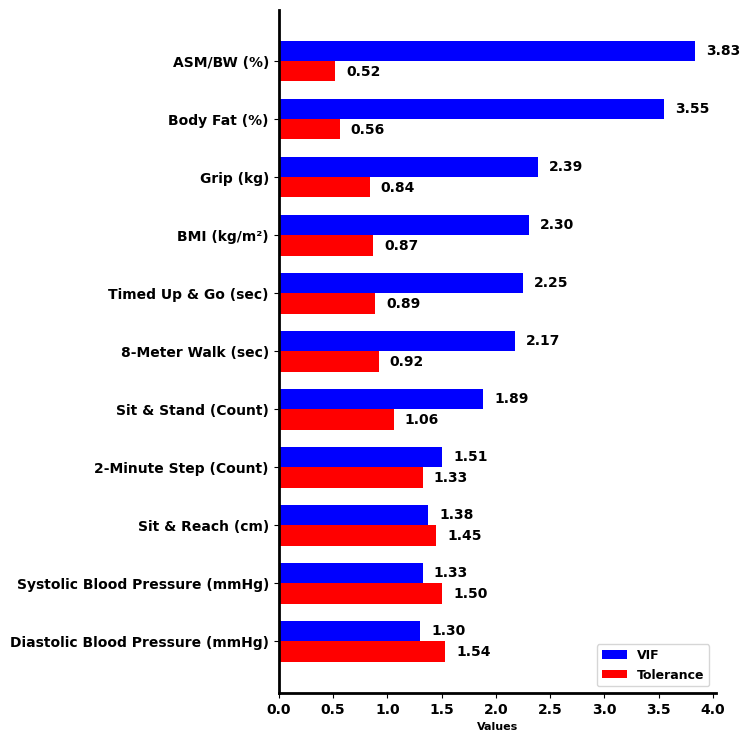

In [9]:
# 데이터셋 설정
# df가 이미 정의되어 있다고 가정합니다.
X = df[['Bodyfat', 'DBP', 'SBP', 'Grip','sitreach', 'BMI', 'sitstand', '2minstepcount', 'TUG',
       '8walktestsec', 'ASM_by_Weight_perc']]

# 변수 레이블 변경
X = X.rename(columns={
    'BMI': 'BMI (kg/m\u00B2)',
    'relativegrip': 'Relative Grip (%)',
    'Bodyfat': 'Body Fat (%)',
    'Age': 'Age (years)',
    'SBP': 'Systolic Blood Pressure (mmHg)',
    'DBP': 'Diastolic Blood Pressure (mmHg)',
    'sitreach': 'Sit & Reach (cm)',
    'Height': 'Height (cm)',
    'Weight': 'Weight (kg)',  
    'Grip': 'Grip (kg)',
    '2minstepcount': '2-Minute Step (Count)',
    'sitstand': 'Sit & Stand (Count)',
    'TUG': 'Timed Up & Go (sec)',
    '8walktestsec': '8-Meter Walk (sec)',
    'ASM_by_Weight_perc': 'ASM/BW (%)'
})

X = sm.add_constant(X)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif["Tolerance"] = 2/vif["VIF Factor"]
vif = vif.sort_values(by='VIF Factor', ascending=False)

# Filter out the 'const' row
vif_filtered = vif[vif['features'] != 'const']

# Create an array of indices for the variables (excluding 'const')
indices = np.arange(len(vif_filtered))

# Bar width for each variable
bar_width = 0.35

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot VIF values
for i, row in enumerate(vif_filtered.iterrows()):
    row = row[1]
    vif_val = row['VIF Factor']
    ax.barh(i - bar_width / 2, vif_val, bar_width, color='blue', label='VIF' if i == 0 else "")
    ax.text(vif_val + 0.1, i - bar_width / 2, f'{vif_val:.2f}', va='center', fontweight='bold')

# Plot Tolerance values
for i, row in enumerate(vif_filtered.iterrows()):
    row = row[1]
    tol_val = row['Tolerance']
    ax.barh(i + bar_width / 2, tol_val, bar_width, color='red', label='Tolerance' if i == 0 else "")
    ax.text(tol_val + 0.1, i + bar_width / 2, f'{tol_val:.2f}', va='center', fontweight='bold')

# Adjust y-ticks to be in the middle of the bars
ax.set_yticks(np.arange(len(vif_filtered)))
ax.set_yticklabels(vif_filtered['features'], fontweight='bold')
    
# Remove unnecessary axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)  # Increase bottom spine width
ax.spines['left'].set_linewidth(2)    # Increase left spine width

# Make x-axis labels and values bold
ax.set_xlabel('Values', fontweight='bold')
ax.set_xticklabels(ax.get_xticks(), fontweight='bold')

# Set y-axis labels
ax.set_yticks(indices)
ax.set_yticklabels(vif_filtered['features'], fontweight='bold')

# Invert y-axis for better visualization
ax.invert_yaxis()

# Add labels and legend
ax.set_xlabel('Values', fontweight='bold', fontsize=8)
#ax.set_title('VIF and Tolerance Values by Variable (excluding const)', fontweight='bold',fontsize=11)
# Set legend labels to bold
legend = ax.legend(fontsize=9)
# Set legend labels to bold
for text in legend.get_texts():
    text.set_fontweight('bold')
    
# Show the plot
plt.tight_layout(pad=10)
plt.show()

PCA 방법으로 그룹 재 조명

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X는 모델에 사용되는 특성들의 데이터프레임입니다.

# PCA 모델 생성 및 학습
pca = PCA(n_components=0.95)  # 설명된 분산의 95%를 유지
X_pca = pca.fit_transform(X_scaled)

# 결과 확인
print("원래 특성 개수:", X.shape[1])
print("축소된 특성 개수:", X_pca.shape[1])


원래 특성 개수: 15
축소된 특성 개수: 10


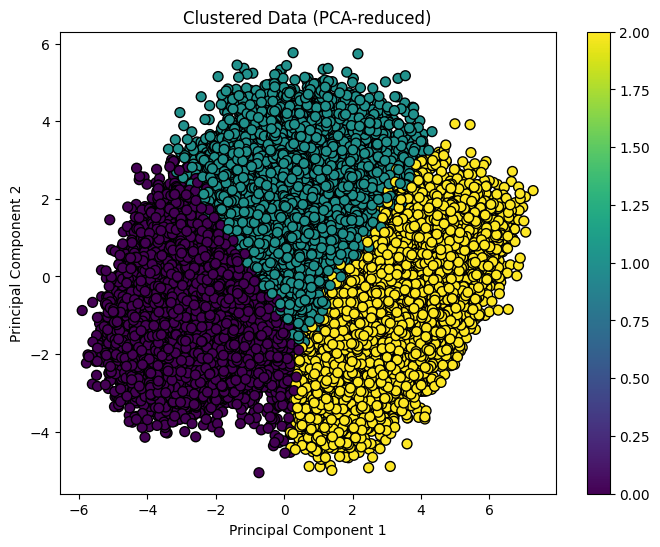

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# PCA 변환된 데이터에 KMeans 클러스터링 적용
kmeans = KMeans(n_clusters=3, random_state=42)  # n_clusters는 예상 그룹 수
clusters = kmeans.fit_predict(X_pca)

# 클러스터 결과 시각화 (PCA의 처음 두 주성분을 사용)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA-reduced)')
plt.colorbar()
plt.show()


In [53]:
df.columns

Index(['Age', 'Height', 'Weight', 'Bodyfat', 'DBP', 'SBP', 'Grip',
       'NormalGrip', 'sitreach', 'BMI', 'sitstand', '2minstepcount', 'TUG',
       '8walktestsec', 'relativegrip', 'Height_m', 'gender_numeric', 'ASM',
       'ASM_by_Weight', 'ASM_by_Weight_perc', 'group', 'group_numberic'],
      dtype='object')

In [ ]:
X = df[['Bodyfat', 'DBP', 'SBP', 'Grip',
       'NormalGrip', 'sitreach', 'BMI', 'sitstand', '2minstepcount', 'TUG',
       '8walktestsec', 'relativegrip', 'ASM_by_Weight_perc', 'group_numberic']]

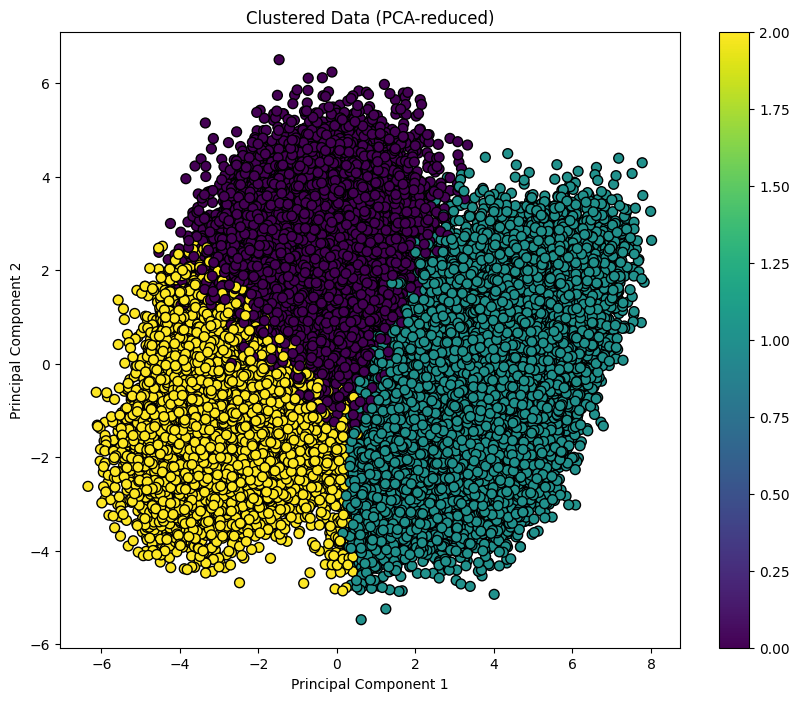

클러스터 중심: [[-1.02129867e+00  1.69957875e+00  3.72185994e-01  7.83680212e-02
   2.67450446e-01  1.28941214e-01 -6.00692427e-02 -1.46641337e-03
   2.12204098e-01  3.86791330e-02  9.50780578e-02]
 [ 3.58692460e+00 -5.96472889e-01  6.86449233e-02 -9.18389935e-02
  -2.65948478e-01 -4.02545835e-02  7.62141320e-02  1.17916171e-03
  -2.15959083e-01 -2.78875678e-02 -5.93360664e-02]
 [-2.69705390e+00 -8.25189193e-01 -3.77774968e-01  2.55768519e-02
   4.03355101e-02 -6.75469734e-02 -2.53599445e-02  5.47849305e-05
   3.68957258e-02 -4.62443704e-03 -2.04808905e-02]]
주성분 개수: 11
각 주성분이 설명하는 분산 비율: [0.41590013 0.13482463 0.12182191 0.06641602 0.04787262 0.0425222
 0.03382214 0.02763633 0.02518583 0.02209812 0.01929329]


In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 예제 데이터셋 'df'을 사용하여 X, y를 정의합니다.
# 이 예시에서는 'df'의 모든 변수들이 수치형 변수라고 가정합니다.
X = df.select_dtypes(include=[np.number])

y = df['group_numberic']

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 모델 생성 및 학습하여 설명된 분산의 95%를 유지하는 차원으로 데이터 축소
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# K-평균 클러스터링 적용 (클러스터 수는 예시로 3으로 설정)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA-reduced)')
plt.show()

# 각 클러스터의 중심 출력
print("클러스터 중심:", kmeans.cluster_centers_)

# 주성분 개수와 각 주성분이 설명하는 분산 비율 출력
print("주성분 개수:", pca.n_components_)
print("각 주성분이 설명하는 분산 비율:", pca.explained_variance_ratio_)


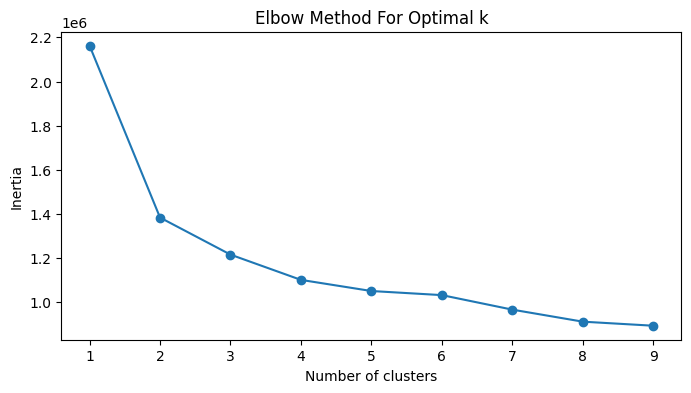

In [57]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 이미 표준화 및 PCA 변환된 데이터를 사용합니다: X_pca

# 1. 데이터의 특성을 고려하여 클러스터링 알고리즘 선택
#    예시: KMeans, 계층적 클러스터링, DBSCAN, Gaussian Mixture

# 2. 클러스터의 개수 결정 (예: 엘보우 방법 사용)
# 엘보우 방법
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# 3. 클러스터링 알고리즘 적용 (여기서는 KMeans를 예로 들겠습니다)
kmeans = KMeans(n_clusters=3, random_state=42)  # n_clusters는 엘보우 방법을 통해 결정
kmeans.fit(X_pca)
labels = kmeans.labels_

# 4. 클러스터링 알고리즘의 가정에 따라 다른 알고리즘도 실험
# 계층적 클러스터링
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(X_pca)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Gaussian Mixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# 5. 결과의 해석 가능성 및 실루엣 점수를 통한 평가
silhouette_avg = silhouette_score(X_pca, labels)
print(f'Silhouette Score for KMeans: {silhouette_avg}')

# 실루엣 점수가 가장 높은 모델을 선택할 수 있습니다.
# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA-reduced) with KMeans')
plt.show()


주성분 설명력 분석

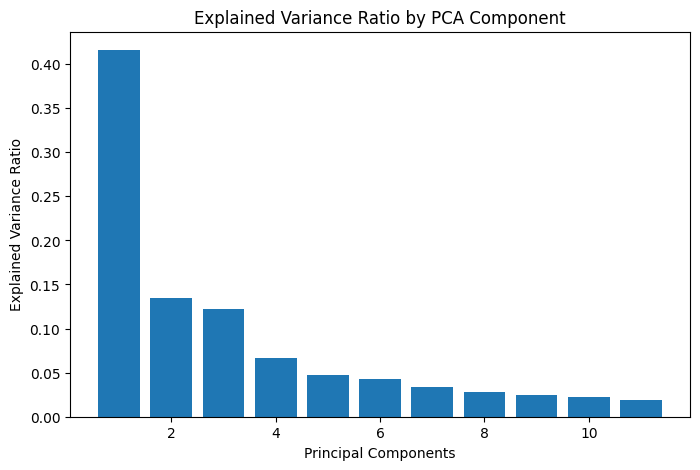

In [56]:
import matplotlib.pyplot as plt

# 주성분의 설명된 분산 비율 시각화
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by PCA Component')
plt.show()


주성분과 원본 특성 간의 관계

In [33]:
import pandas as pd

# PCA 로딩 확인
loadings = pca.components_

# 주성분에 대한 새로운 열 이름 생성
components_names = [f"PC{i+1}" for i in range(loadings.shape[0])]

# 로딩 매트릭스 생성
loading_matrix = pd.DataFrame(loadings.T, columns=components_names)  # Transpose loadings to match the correct shape

print(loading_matrix)



         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0   0.000000 -0.000000  0.000000 -0.000000 -0.000000  0.000000 -0.000000   
1   0.338099 -0.215163 -0.147760 -0.223661 -0.109712  0.058851  0.002500   
2  -0.025840 -0.155207 -0.559900  0.421171  0.069967  0.036539 -0.681432   
3  -0.053524 -0.115430 -0.594763  0.338844 -0.118489 -0.079643  0.682608   
4  -0.351153 -0.003194 -0.218944 -0.361989  0.204863  0.036167 -0.026631   
5  -0.353261 -0.008292 -0.220437 -0.367735  0.200399  0.045899 -0.020917   
6   0.082820 -0.363623  0.155547  0.191283  0.790561  0.028089  0.163056   
7   0.208588 -0.236548 -0.333974 -0.564854 -0.106978  0.027677 -0.004881   
8  -0.238515 -0.376024  0.096428  0.011921 -0.122246 -0.127869  0.136181   
9  -0.179980 -0.379541  0.132135 -0.022223 -0.144378 -0.801626 -0.142167   
10  0.240573  0.382471 -0.146755 -0.051844  0.236633 -0.385652 -0.000714   
11  0.222285  0.400674 -0.161530 -0.083684  0.222758 -0.417867  0.045942   
12 -0.383027

축소된 데이터셋을 사용한 모델 학습 및 평가

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 분할
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train_pca, y_train)

# 모델 평가
y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [36]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# 모델 정의 (로지스틱 회귀)
model = LogisticRegression()

# 모델 학습
model.fit(X_train, y_train)

# 훈련 세트와 테스트 세트에서의 예측
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 정확도 계산
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 분류 리포트 및 혼동 행렬
classification_report_test = classification_report(y_test, y_test_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# 교차 검증
cross_val_scores = cross_val_score(model, X_pca, y, cv=5)

# 결과 출력
print(f"훈련 세트 정확도: {train_accuracy}")
print(f"테스트 세트 정확도: {test_accuracy}")
print("\n테스트 세트 분류 리포트:\n", classification_report_test)
print("테스트 세트 혼동 행렬:\n", confusion_matrix_test)
print(f"\n교차 검증 점수: {cross_val_scores}")
print(f"교차 검증 평균 점수: {cross_val_scores.mean()}")

# 과적합 및 데이터 누수 점검
if train_accuracy > test_accuracy:
    print("\n모델이 과적합될 가능성이 있습니다. 훈련 세트의 정확도가 테스트 세트보다 높습니다.")
else:
    print("\n모델이 과적합되지 않았습니다. 훈련 세트와 테스트 세트에서 유사한 성능을 보입니다.")

# 데이터 누수 점검
if train_accuracy == 1.0:
    print("\n데이터 누수가 있을 수 있습니다. 훈련 데이터에서 완벽한 성능을 보이는 것은 의심스러운 부분입니다.")


훈련 세트 정확도: 0.999986716435754
테스트 세트 정확도: 1.0

테스트 세트 분류 리포트:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00     23910
           2       1.00      1.00      1.00      8354

    accuracy                           1.00     32264
   macro avg       1.00      1.00      1.00     32264
weighted avg       1.00      1.00      1.00     32264

테스트 세트 혼동 행렬:
 [[23910     0]
 [    0  8354]]

교차 검증 점수: [0.99995351 1.         1.         0.99995351 1.        ]
교차 검증 평균 점수: 0.9999814031335721

모델이 과적합되지 않았습니다. 훈련 세트와 테스트 세트에서 유사한 성능을 보입니다.


PCA 기반 데이터 누수 점검

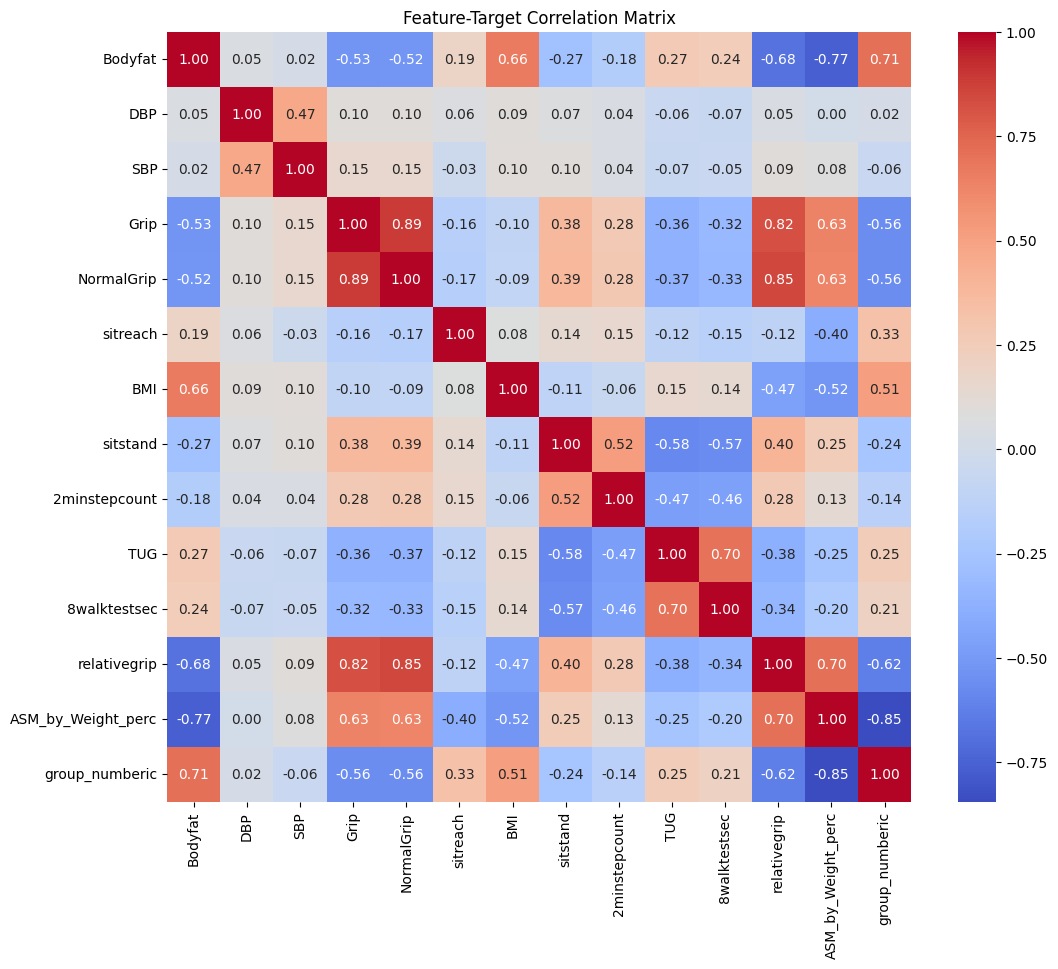

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 특성과 타겟 변수 간의 상관관계 계산
correlation_matrix = pd.concat([X, y], axis=1).corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature-Target Correlation Matrix")
plt.show()


In [40]:
from sklearn.model_selection import train_test_split

# 독립 변수와 종속 변수를 분리
X = df.drop(columns=['group_numberic'])  # 'group_numberic'를 타겟 변수로 가정
y = df['group_numberic']

# 범주형 데이터를 제외하고 수치형 데이터만 선택합니다.
X_numeric = X.select_dtypes(include=[np.number])

# 데이터를 훈련 세트와 독립적인 테스트 세트로 분할
X_train, X_independent, y_train, y_independent = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# 데이터 표준화 및 PCA 변환
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_independent_scaled = scaler.transform(X_independent)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_independent_pca = pca.transform(X_independent_scaled)

# 모델 학습 및 독립적인 테스트 세트에서의 성능 평가
model = LogisticRegression()
model.fit(X_train_pca, y_train)
y_independent_pred = model.predict(X_independent_pca)
independent_accuracy = accuracy_score(y_independent, y_independent_pred)

print(f"독립적인 테스트 데이터셋 정확도: {independent_accuracy}")



독립적인 테스트 데이터셋 정확도: 0.9951648147287182


In [43]:
from sklearn.preprocessing import OneHotEncoder

# 원-핫 인코더 생성
encoder = OneHotEncoder()

# 범주형 데이터만 선택하여 인코딩
X_categorical = X.select_dtypes(include=['object'])
X_encoded = encoder.fit_transform(X_categorical).toarray()

# 인코딩된 범주형 데이터와 수치형 데이터를 결합
X_combined = np.hstack([X.select_dtypes(include=[np.number]).values, X_encoded])

# 데이터 분할
X_train, X_independent, y_train, y_independent = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_independent_scaled = scaler.transform(X_independent)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_independent_pca = pca.transform(X_independent_scaled)

# 모델 학습 및 독립적인 테스트 세트에서의 성능 평가
model = LogisticRegression()
model.fit(X_train_pca, y_train)
y_independent_pred = model.predict(X_independent_pca)
independent_accuracy = accuracy_score(y_independent, y_independent_pred)

print(f"독립적인 테스트 데이터셋 정확도: {independent_accuracy}")

# 다른 코드는 이전과 동일하게 유지


독립적인 테스트 데이터셋 정확도: 1.0


Ridge 방법으로 그룹 재조명

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 독립 변수와 종속 변수 분리
X = df[['Bodyfat', 'DBP', 'SBP', 'Grip', 'NormalGrip', 'sitreach', 'BMI', 'sitstand', '2minstepcount', 'TUG', '8walktestsec', 'relativegrip', 'ASM_by_Weight_perc']]
y = df['group_numberic']

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Ridge 모델 생성 및 훈련
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# 훈련 세트와 테스트 세트에 대한 예측
y_train_pred = ridge.predict(X_train_scaled)
y_test_pred = ridge.predict(X_test_scaled)

# 성능 평가
print("Ridge - Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Ridge - Test MSE:", mean_squared_error(y_test, y_test_pred))


Ridge - Train MSE: 0.050337043433982834
Ridge - Test MSE: 0.05016216647907936


Lasso 방법으로 그룹 재조명

In [23]:
from sklearn.linear_model import Lasso

# Lasso 모델 생성 및 훈련
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

# 훈련 세트와 테스트 세트에 대한 예측
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# 성능 평가
print("Lasso - Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Lasso - Test MSE:", mean_squared_error(y_test, y_test_pred))



Lasso - Train MSE: 0.05216796009301848
Lasso - Test MSE: 0.05196677847673355


1.Ridge 회귀에 대한 하이퍼파라미터 튜닝

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge 회귀 모델을 위한 하이퍼파라미터 그리드 설정
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_ridge.fit(X_train_scaled, y_train)

# 최적의 파라미터와 그에 따른 MSE 값 출력
print("Ridge 최적의 파라미터:", grid_search_ridge.best_params_)
print("Ridge 최적의 MSE:", -grid_search_ridge.best_score_)


Ridge 최적의 파라미터: {'alpha': 10}
Ridge 최적의 MSE: 0.05036294391165582


2. Lasso 회귀에 대한 하이퍼파라미터 튜닝

In [25]:
from sklearn.linear_model import Lasso

# Lasso 회귀 모델을 위한 하이퍼파라미터 그리드 설정
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_lasso.fit(X_train_scaled, y_train)

# 최적의 파라미터와 그에 따른 MSE 값 출력
print("Lasso 최적의 파라미터:", grid_search_lasso.best_params_)
print("Lasso 최적의 MSE:", -grid_search_lasso.best_score_)


Lasso 최적의 파라미터: {'alpha': 0.0001}
Lasso 최적의 MSE: 0.05036291204274177


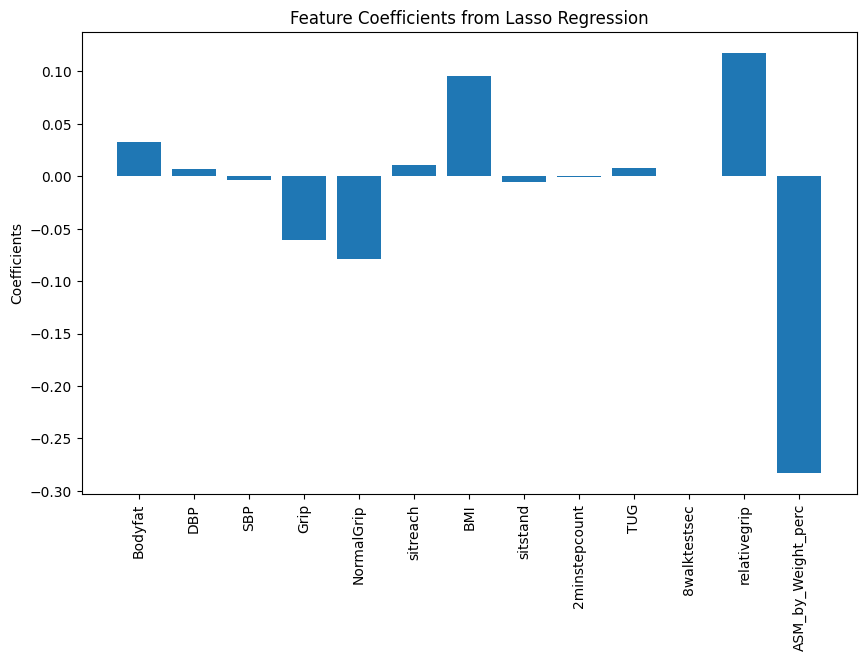

In [26]:
import matplotlib.pyplot as plt

lasso = Lasso(alpha=0.0001).fit(X_train_scaled, y_train)
coefficients = lasso.coef_

plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(range(len(coefficients)), X_train.columns, rotation=90)
plt.ylabel('Coefficients')
plt.title('Feature Coefficients from Lasso Regression')
plt.show()


In [27]:
import time

start_time = time.time()
lasso.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"Lasso Training Time: {end_time - start_time} seconds")


Lasso Training Time: 0.1133575439453125 seconds


모델의 견고성(robustness)

In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f"Lasso Cross-Validated MSE: {-scores.mean()} (±{scores.std()})")


Lasso Cross-Validated MSE: 1.0459774477061145e-08 (±5.365920314937055e-10)


과적합 점검

In [29]:
from sklearn.metrics import mean_squared_error

# Lasso 모델 학습
lasso = Lasso(alpha=0.0001).fit(X_train_scaled, y_train)

# 훈련 데이터와 테스트 데이터에 대한 예측
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# 훈련 세트와 테스트 세트의 MSE 계산
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"훈련 세트 MSE: {mse_train}")
print(f"테스트 세트 MSE: {mse_test}")


훈련 세트 MSE: 0.05033762377788832
테스트 세트 MSE: 0.05016200477647839


실제 응용에서의 성능 평가

In [30]:
# 독립적인 검증 데이터 로딩 (가정)
X_validation, y_validation = load_validation_data()

# 데이터 표준화
X_validation_scaled = scaler.transform(X_validation)

# 독립적인 검증 데이터에 대한 예측
y_validation_pred = lasso.predict(X_validation_scaled)

# 검증 세트의 MSE 계산
mse_validation = mean_squared_error(y_validation, y_validation_pred)
print(f"검증 세트 MSE: {mse_validation}")


NameError: name 'load_validation_data' is not defined